# NLP tf-idf pipeline with cuML + Dask

In [1]:
%matplotlib inline
import cupy as cp
from cuml.feature_extraction.text import HashingVectorizer
from dask_cuda import LocalCUDACluster
from dask.distributed import Client, wait
from cuml.dask.common import to_sparse_dask_array
from cuml.dask.feature_extraction.text import TfidfTransformer
import dask_cudf
import cudf
import nltk
import dask
from timeit import default_timer as timer
import time
import pickle
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class SimpleTimer:
    def __init__(self):
        self.start = None
        self.end = None
        self.elapsed = None

    def __enter__(self):
        self.start = time.perf_counter_ns()
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time.perf_counter_ns()
        self.elapsed = self.end - self.start

def visualize_data(path):

    data = pickle.load(open(path, "rb"))
    df_list = [["n_workers", "sample_run", "overall", "data_read", "data_preprocessing", "hashing_vectorizer", "tfidf_transformer", "nrows"]]
    for n_workers in data:
        temp_data = data[n_workers]
        if isinstance(temp_data, float):
            continue
        results = temp_data["sample_run_results"]
        for sample_run in range(len(results)):
            timings = results[sample_run]
            df_list.append([n_workers, sample_run, timings["overall"]/1e9, 
                           timings["data_read"]/1e9, timings["data_preprocessing"]/1e9,timings["hashing_vectorizer"]/1e9, 
                           timings["tfidf_transformer"]/1e9, timings["nrows"]])
    
    perf_df = pd.DataFrame(df_list[1:], columns=df_list[0])
    fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
    dd = pd.melt(perf_df, 
                 id_vars=['n_workers'],
                 value_vars=['overall','data_read', 'data_preprocessing', 'hashing_vectorizer','tfidf_transformer'],
                 var_name='latency')
    sns.boxplot(x='latency',y='value',data=dd, orient="v", hue="n_workers")
    plt.show()
    return perf_df, dd 

In [3]:
nltk.download('stopwords')
STOPWORDS = nltk.corpus.stopwords.words('english')
PUNCTUATIONS = [ '!', '"', '#', '$', '%', '&', '(', ')', '*', '+', '-', '.', '/',  '\\', ':', ';', '<', '=', '>',
           '?', '@', '[', ']', '^', '_', '`', '{', '|', '}', '\t','\n',"'",",",'~' , '—']

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nfs/anirband/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Setting up the Dask cuda cluster

In [4]:
# Create a local CUDA cluster
cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES="0,1,2,3,4,5,6,7")
client = Client(cluster)

distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
distributed.preloading - INFO - Import preload module: dask_cuda.initialize


In [5]:
client

Connection method: Cluster object,Cluster type: LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:45527,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:40821,Total threads: 1
Dashboard: http://127.0.0.1:39703/status,Memory: 125.97 GiB
Nanny: tcp://127.0.0.1:44675,


## Helper Functions

In [6]:
def scale_workers(client, n_workers, timeout=300):
    client.cluster.scale(n_workers)
    
    m = len(client.has_what().keys())    
    start = end = time.perf_counter_ns()
    while ((m != n_workers) and (((end - start) / 1e9) < timeout) ):
        time.sleep(5)
        m = len(client.has_what().keys())
        
        end = time.perf_counter_ns()
        
    if (((end - start) / 1e9) >= timeout):
        raise RuntimeError(f"Failed to rescale cluster in {timeout} sec."
              "Try increasing timeout for very large containers, and verify available compute resources.")

def read_data(client, parquet_path, persist_flag=True):
    data = dask_cudf.read_parquet(parquet_path)
    if persist_flag:
        with dask.annotate(workers=set(client.has_what().keys())):
            data = client.persist(data)
        wait(data)
    print(data.shape[0].compute())
    return data

def text_preprocessor(data, client, column_name, PUNCTUATIONS, STOPWORDS, persist_flag=True):
    data = data[data[column_name].notnull()]
    data[column_name] = (data[column_name]
                         .str.lower()
                         .str.replace(PUNCTUATIONS, [" "]*len(PUNCTUATIONS), regex=False)
                         .str.replace_tokens(STOPWORDS, "")
                         .str.normalize_spaces()
                         .str.strip())
    if persist_flag:
        with dask.annotate(workers=set(client.has_what().keys())):
            data = client.persist(data)
        wait(data)
    print(data.shape[0].compute())
    return data

def hashing_vectorizer(data, client, column_name, persist_flag):
    vectorizer = HashingVectorizer(stop_words='english', preprocessor=None)
    # Meta is an empty dataframe matches the dtypes and columns of the output
    meta = dask.array.from_array(cp.sparse.csr_matrix(cp.zeros(1, dtype=cp.float32))) 
    hashing_vectorized = data[column_name].map_partitions(vectorizer.fit_transform, meta=meta).astype(cp.float32)
    if persist_flag:
        with dask.annotate(workers=set(client.has_what().keys())):
            hashing_vectorized = client.persist(hashing_vectorized)
        wait(hashing_vectorized)
        hashing_vectorized.compute_chunk_sizes()
    print(hashing_vectorized.shape)
    return hashing_vectorized

def tfidf_transformer(data, client, persist_flag):
    multi_gpu_transformer = TfidfTransformer()
    result = multi_gpu_transformer.fit_transform(data)
    if persist_flag:
        with dask.annotate(workers=set(client.has_what().keys())):
            result = client.persist(result)
        wait(result)
        result.compute_chunk_sizes()
    print(result.shape)
    return result

def execute_full_pipeline(n, i, client, parquet_path, worker_counts=[1], result_path="./results.pkl", persist_flag=True):
    sample_record = {"overall":0, "data_read":0, "hashing_vectorizer":0, "tfid_transformer":0, "data_preprocessing":0, "nrows":0}
    client.restart()
    with SimpleTimer() as timer:
        data = read_data(client, parquet_path, persist_flag)
    sample_record["data_read"]=timer.elapsed

    with SimpleTimer() as timer:
        data = text_preprocessor(data, client, "review_body", PUNCTUATIONS, STOPWORDS, persist_flag)
    sample_record["data_preprocessing"]=timer.elapsed
    
    with SimpleTimer() as timer:
        hashing_vectorized = hashing_vectorizer(data, client, "review_body", persist_flag)
    sample_record["hashing_vectorizer"]=timer.elapsed
    
    with SimpleTimer() as timer:
        result = tfidf_transformer(hashing_vectorized, client, persist_flag=True)
    sample_record["tfidf_transformer"]=timer.elapsed
    
    print(f"Workers:{n}, Sample Run:{i}, Finished loading data in {sample_record['data_read']}s")
    print(f"Workers:{n}, Sample Run:{i}, Finished preprocessing data in {sample_record['data_preprocessing']}s")
    print(f"Workers:{n}, Sample Run:{i}, Finished fitting HashVectorizer in {sample_record['hashing_vectorizer']}s")
    print(f"Workers:{n}, Sample Run:{i}, Finished fitting IDF Transformer in {sample_record['tfidf_transformer']}s")
    return data, result, sample_record
    

## Benchmarking Code

In [7]:
def performance_numbers(client, parquet_path, worker_counts=[1], samples=1, result_path="./results.pkl", persist_flag=True):
    """
    Main function to perform the performance sweep
    """
    overall_perf_result = {}
    
    for n in worker_counts: 
        overall_perf_result[n]={"sample_run_results": []}
        scale_workers(client, n)
        
        for i in tqdm(range(samples)): 
            with SimpleTimer() as overalltimer:
                data, result, sample_record = execute_full_pipeline(n, i, client, parquet_path, worker_counts=[1], result_path=result_path, persist_flag=persist_flag)
            sample_record["overall"]=overalltimer.elapsed
            sample_record["nrows"]=data.shape[0].compute()
            print(f"Workers:{n}, Sample Run:{i}, Finished executing full pipeline in {overalltimer.elapsed}s")
            overall_perf_result[n]["sample_run_results"].append(sample_record)
    
    with open(result_path, "wb") as file:
        pickle.dump(overall_perf_result, file)

In [8]:
#parquet_path = 's3://amazon-reviews-pds/parquet/product_category=Camera/*.parquet'
dataset = "Books"
parquet_path = f'./data/product_category={dataset}'
model_kwargs = {"text_preprocessor":text_preprocessor}
samples = 5
worker_counts = [2,4,6,8]
result_path = f"./results/result_poc_nlp_dask_{dataset}_persist.pkl"

## Benchmark latency by materializing the intermediate dataframe(s) in every stage

In [8]:
%%time
performance_numbers(client, parquet_path=parquet_path, worker_counts=worker_counts, samples=samples, result_path=result_path, persist_flag=True)

  0%|                                                                                                                                                                                      | 0/5 [00:00<?, ?it/s]distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize


20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(20725971, 1048576)
[I] [20:58:02.948860] [Delayed('_merge_stats_to_model-9f72b5cd-a571-4aa2-b112-dc541b5752b4')]
[I] [20:58:02.951439] [Delayed('_merge_stats_to_model-2a6266fd-9f5e-43ab-9996-cee0c370f4f4')]
[I] [20:58:03.410401] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-9f72b5cd-a571-4aa2-b112-dc541b5752b4>]
[I] [20:58:03.410742] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-2a6266fd-9f5e-43ab-9996-cee0c370f4f4>]
[I] [20:58:03.423662] [Delayed('_merge_stats_to_model-272bd385-534d-4d0b-bb3d-13b11f90ec42')]


 20%|██████████████████████████████████▊                                                                                                                                           | 1/5 [01:37<06:30, 97.55s/it]

(20725971, 1048576)
Workers:2, Sample Run:0, Finished loading data in 21384177810s
Workers:2, Sample Run:0, Finished preprocessing data in 28029037429s
Workers:2, Sample Run:0, Finished fitting HashVectorizer in 38071542922s
Workers:2, Sample Run:0, Finished fitting IDF Transformer in 7139783258s
Workers:2, Sample Run:0, Finished executing full pipeline in 97397786491s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize


20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(20725971, 1048576)
[I] [20:59:13.776563] [Delayed('_merge_stats_to_model-23bf05fa-882b-4ae1-9bad-845dd34b69de')]
[I] [20:59:13.778903] [Delayed('_merge_stats_to_model-0eb8d2bf-9e36-496c-a497-d5d8f297c29e')]
[I] [20:59:14.102690] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-23bf05fa-882b-4ae1-9bad-845dd34b69de>]
[I] [20:59:14.102766] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-0eb8d2bf-9e36-496c-a497-d5d8f297c29e>]
[I] [20:59:14.108943] [Delayed('_merge_stats_to_model-ee7aea08-d2a9-4172-b69c-fe653f5a6bad')]
(20725971, 1048576)
Workers:2, Sample Run:1, Finished loading data in 5809526012s
Workers:2, Sample Run:1, Finished preprocessing data in 26378286779s
Workers:2, Sample Run:1, Finished fitting HashVectorizer in 28801652148s
Workers:2, Sample Run:1, Finished fitting IDF Transformer in 2945099872s


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 2/5 [02:45<04:00, 80.04s/it]

Workers:2, Sample Run:1, Finished executing full pipeline in 67458149089s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize


20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(20725971, 1048576)
[I] [21:00:21.434882] [Delayed('_merge_stats_to_model-256ffac5-2c34-47cd-a523-adb5c110118b')]
[I] [21:00:21.441202] [Delayed('_merge_stats_to_model-18b37e0a-6fd4-4197-9e8f-15719cdac5df')]
[I] [21:00:21.501733] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-256ffac5-2c34-47cd-a523-adb5c110118b>]
[I] [21:00:21.501976] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-18b37e0a-6fd4-4197-9e8f-15719cdac5df>]
[I] [21:00:21.507967] [Delayed('_merge_stats_to_model-6bdc9109-fc7b-4833-8b02-00ebe030e545')]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 3/5 [03:52<02:28, 74.27s/it]

(20725971, 1048576)
Workers:2, Sample Run:2, Finished loading data in 5835288151s
Workers:2, Sample Run:2, Finished preprocessing data in 26397000542s
Workers:2, Sample Run:2, Finished fitting HashVectorizer in 28845398233s
Workers:2, Sample Run:2, Finished fitting IDF Transformer in 2837632528s
Workers:2, Sample Run:2, Finished executing full pipeline in 67355433284s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize


20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(20725971, 1048576)
[I] [21:01:28.957664] [Delayed('_merge_stats_to_model-0302dcfc-291d-4d35-95ae-4aa6247fc3d0')]
[I] [21:01:28.962589] [Delayed('_merge_stats_to_model-91711cf9-a322-4fbc-a111-5c1bd335dd89')]
[I] [21:01:29.284665] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-0302dcfc-291d-4d35-95ae-4aa6247fc3d0>]
[I] [21:01:29.284940] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-91711cf9-a322-4fbc-a111-5c1bd335dd89>]
[I] [21:01:29.290530] [Delayed('_merge_stats_to_model-813ea6f3-8b67-47a6-987c-6f2a49262369')]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4/5 [05:00<01:11, 71.72s/it]

(20725971, 1048576)
Workers:2, Sample Run:3, Finished loading data in 5799130688s
Workers:2, Sample Run:3, Finished preprocessing data in 26383668805s
Workers:2, Sample Run:3, Finished fitting HashVectorizer in 28815265536s
Workers:2, Sample Run:3, Finished fitting IDF Transformer in 3127665121s
Workers:2, Sample Run:3, Finished executing full pipeline in 67614172683s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize


20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(20725971, 1048576)
[I] [21:02:36.377933] [Delayed('_merge_stats_to_model-e5965c76-efb6-40d0-92b0-b84d6db51458')]
[I] [21:02:36.380286] [Delayed('_merge_stats_to_model-7728616d-a192-40eb-991d-c3d448f2e6d2')]
[I] [21:02:36.698420] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-e5965c76-efb6-40d0-92b0-b84d6db51458>]
[I] [21:02:36.698725] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-7728616d-a192-40eb-991d-c3d448f2e6d2>]
[I] [21:02:36.704752] [Delayed('_merge_stats_to_model-db14f870-4a4b-4f58-8089-26bc7b83f4a0')]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:07<00:00, 73.58s/it]

(20725971, 1048576)
Workers:2, Sample Run:4, Finished loading data in 5835560510s
Workers:2, Sample Run:4, Finished preprocessing data in 26023809274s
Workers:2, Sample Run:4, Finished fitting HashVectorizer in 28798089606s
Workers:2, Sample Run:4, Finished fitting IDF Transformer in 3090131882s
Workers:2, Sample Run:4, Finished executing full pipeline in 67214077142s



distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
  0%|                                                                                                                                                                                      | 0/5 [00:00<?, ?it/s]/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda

20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(20725971, 1048576)
[I] [21:03:20.457036] [Delayed('_merge_stats_to_model-e20976ea-462e-4c82-beba-e940397ee5d7')]
[I] [21:03:20.458545] [Delayed('_merge_stats_to_model-8464e3d7-f5ad-4c1e-b6a5-1908b23c66ca')]
[I] [21:03:20.459331] [Delayed('_merge_stats_to_model-4c23e3ac-59d4-4e20-aabf-7e02fcf3e9be')]
[I] [21:03:20.460213] [Delayed('_merge_stats_to_model-d18a2353-9b89-44aa-b3a7-edbcbd2b116a')]
[I] [21:03:20.505698] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-e20976ea-462e-4c82-beba-e940397ee5d7>]
[I] [21:03:20.505940] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-8464e3d7-f5ad-4c1e-b6a5-1908b23c66ca>]
[I] [21:03:20.506082] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-4c23e3ac-59d4-4e20-aabf-7e02fcf3e9be>]
[I] [21:03:20.506211] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-d18a2353-9b89-44aa-b3a7-edbcbd2b116a>]
[I] [21:03:20.512854] [Delayed('_merge

 20%|██████████████████████████████████▊                                                                                                                                           | 1/5 [00:38<02:34, 38.58s/it]

(20725971, 1048576)
Workers:4, Sample Run:0, Finished loading data in 3050370965s
Workers:4, Sample Run:0, Finished preprocessing data in 14898396646s
Workers:4, Sample Run:0, Finished fitting HashVectorizer in 14973456203s
Workers:4, Sample Run:0, Finished fitting IDF Transformer in 2030947857s
Workers:4, Sample Run:0, Finished executing full pipeline in 38526369681s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
dist

20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(20725971, 1048576)
[I] [21:03:59.869484] [Delayed('_merge_stats_to_model-0118234c-4f9f-45c0-98e7-c935027cdef7')]
[I] [21:03:59.870195] [Delayed('_merge_stats_to_model-fb3eb3a3-c632-4f63-913f-c8fa3da82a02')]
[I] [21:03:59.870863] [Delayed('_merge_stats_to_model-cee06eeb-1173-4fdb-8ae1-d6839e50733f')]
[I] [21:03:59.872210] [Delayed('_merge_stats_to_model-23f4239f-8fde-4c2a-821c-b44f01509cb4')]
[I] [21:03:59.909439] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-0118234c-4f9f-45c0-98e7-c935027cdef7>]
[I] [21:03:59.909517] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-fb3eb3a3-c632-4f63-913f-c8fa3da82a02>]
[I] [21:03:59.909749] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-cee06eeb-1173-4fdb-8ae1-d6839e50733f>]
[I] [21:03:59.909880] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-23f4239f-8fde-4c2a-821c-b44f01509cb4>]
[I] [21:03:59.916143] [Delayed('_merge

 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 2/5 [01:17<01:57, 39.03s/it]

(20725971, 1048576)
Workers:4, Sample Run:1, Finished loading data in 3094329230s
Workers:4, Sample Run:1, Finished preprocessing data in 15010813061s
Workers:4, Sample Run:1, Finished fitting HashVectorizer in 15142235609s
Workers:4, Sample Run:1, Finished fitting IDF Transformer in 1968813864s
Workers:4, Sample Run:1, Finished executing full pipeline in 39295087784s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
dist

20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(20725971, 1048576)
[I] [21:04:39.291232] [Delayed('_merge_stats_to_model-84820496-eb1c-4bb6-b3a6-217c377b998b')]
[I] [21:04:39.292024] [Delayed('_merge_stats_to_model-3bbdf797-8157-4ca9-a266-461702a1bfbd')]
[I] [21:04:39.292787] [Delayed('_merge_stats_to_model-01082679-e76f-49a2-ad70-9321d500e1f4')]
[I] [21:04:39.294081] [Delayed('_merge_stats_to_model-cbfd3b5f-45b1-4487-a8b5-42774ec6fa27')]
[I] [21:04:39.332960] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-84820496-eb1c-4bb6-b3a6-217c377b998b>]
[I] [21:04:39.333220] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-3bbdf797-8157-4ca9-a266-461702a1bfbd>]
[I] [21:04:39.333364] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-01082679-e76f-49a2-ad70-9321d500e1f4>]
[I] [21:04:39.333504] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-cbfd3b5f-45b1-4487-a8b5-42774ec6fa27>]
[I] [21:04:39.340209] [Delayed('_merge

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 3/5 [01:57<01:18, 39.22s/it]

(20725971, 1048576)
Workers:4, Sample Run:2, Finished loading data in 3051332674s
Workers:4, Sample Run:2, Finished preprocessing data in 14920598624s
Workers:4, Sample Run:2, Finished fitting HashVectorizer in 15126895288s
Workers:4, Sample Run:2, Finished fitting IDF Transformer in 2007189908s
Workers:4, Sample Run:2, Finished executing full pipeline in 39378188993s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
dist

20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(20725971, 1048576)
[I] [21:05:22.300429] [Delayed('_merge_stats_to_model-3a46d505-775d-471b-8cd0-b22d938a46b7')]
[I] [21:05:22.301753] [Delayed('_merge_stats_to_model-1c4dba1f-2a49-45d6-aeef-952bef607805')]
[I] [21:05:22.302452] [Delayed('_merge_stats_to_model-5c338ecb-f414-4ee6-8e22-68f9a777aea9')]
[I] [21:05:22.303122] [Delayed('_merge_stats_to_model-e29bdf6a-fdf1-45ac-b2bb-3517617e9752')]
[I] [21:05:22.342216] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-3a46d505-775d-471b-8cd0-b22d938a46b7>]
[I] [21:05:22.342454] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-1c4dba1f-2a49-45d6-aeef-952bef607805>]
[I] [21:05:22.342591] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-5c338ecb-f414-4ee6-8e22-68f9a777aea9>]
[I] [21:05:22.342717] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-e29bdf6a-fdf1-45ac-b2bb-3517617e9752>]
[I] [21:05:22.348889] [Delayed('_merge

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4/5 [02:40<00:40, 40.73s/it]

(20725971, 1048576)
Workers:4, Sample Run:3, Finished loading data in 3100560138s
Workers:4, Sample Run:3, Finished preprocessing data in 17258673758s
Workers:4, Sample Run:3, Finished fitting HashVectorizer in 16345044465s
Workers:4, Sample Run:3, Finished fitting IDF Transformer in 2084056593s
Workers:4, Sample Run:3, Finished executing full pipeline in 42993542490s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
dist

20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(20725971, 1048576)
[I] [21:06:01.631343] [Delayed('_merge_stats_to_model-7fc7d077-8e69-47d2-a57c-41d3323ba8e3')]
[I] [21:06:01.632802] [Delayed('_merge_stats_to_model-0869a9fc-855f-4c29-80c4-9dcbb24a27f1')]
[I] [21:06:01.633560] [Delayed('_merge_stats_to_model-419ce223-06ba-4209-b915-719b60e7e516')]
[I] [21:06:01.634281] [Delayed('_merge_stats_to_model-2d34cac2-e257-4ec8-954e-f78a42b10b8e')]
[I] [21:06:01.673787] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-7fc7d077-8e69-47d2-a57c-41d3323ba8e3>]
[I] [21:06:01.674033] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-0869a9fc-855f-4c29-80c4-9dcbb24a27f1>]
[I] [21:06:01.674180] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-419ce223-06ba-4209-b915-719b60e7e516>]
[I] [21:06:01.674314] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-2d34cac2-e257-4ec8-954e-f78a42b10b8e>]
[I] [21:06:01.680974] [Delayed('_merge

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:19<00:00, 39.95s/it]

(20725971, 1048576)
Workers:4, Sample Run:4, Finished loading data in 3066925217s
Workers:4, Sample Run:4, Finished preprocessing data in 14920007166s
Workers:4, Sample Run:4, Finished fitting HashVectorizer in 15072923079s
Workers:4, Sample Run:4, Finished fitting IDF Transformer in 2024723943s
Workers:4, Sample Run:4, Finished executing full pipeline in 39259243508s



distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
  0%|                                                                                                                                                                                      | 0/5 [00:00<?, ?it/s]/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home

20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(20725971, 1048576)
[I] [21:06:37.197367] [Delayed('_merge_stats_to_model-71b8ac18-f62f-43b2-b561-d7a66907801b')]
[I] [21:06:37.198231] [Delayed('_merge_stats_to_model-9f3b78af-3185-47c1-b58f-81186782ba69')]
[I] [21:06:37.198496] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-a77b408d-bb50-474e-94fa-bb3f986ccdaf>]
[I] [21:06:37.199108] [Delayed('_merge_stats_to_model-1964fd60-0f8a-4a4c-a2ac-dde62370511b')]
[I] [21:06:37.199346] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-09a23476-28bf-4bdc-8ddd-8af67f8b7f76>]
[I] [21:06:37.199989] [Delayed('_merge_stats_to_model-bcdbb3cd-bf9f-41cb-afd9-6665c9af389d')]
[I] [21:06:37.227860] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-71b8ac18-f62f-43b2-b561-d7a66907801b>]
[I] [21:06:37.228110] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-9f3b78af-3185-47c1-b58f-81186782ba69>]
[I] [21:06:37.228242] [<Future: finished, type: cuml

 20%|██████████████████████████████████▊                                                                                                                                           | 1/5 [00:30<02:02, 30.57s/it]

(20725971, 1048576)
Workers:6, Sample Run:0, Finished loading data in 2829203105s
Workers:6, Sample Run:0, Finished preprocessing data in 10071372724s
Workers:6, Sample Run:0, Finished fitting HashVectorizer in 10901905243s
Workers:6, Sample Run:0, Finished fitting IDF Transformer in 2027288996s
Workers:6, Sample Run:0, Finished executing full pipeline in 30520778169s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when 

20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(20725971, 1048576)
[I] [21:07:09.849870] [Delayed('_merge_stats_to_model-79a217e1-d811-4029-9f61-bdbb28bf7ff6')]
[I] [21:07:09.850732] [Delayed('_merge_stats_to_model-b0cf72c8-9ee9-4c69-a038-3ea4ee204133')]
[I] [21:07:09.851487] [Delayed('_merge_stats_to_model-5a5d363f-79fc-4a0d-a1f8-244867aff3cd')]
[I] [21:07:09.852330] [Delayed('_merge_stats_to_model-487138de-b038-484d-8ef4-696625e6fc0a')]
[I] [21:07:09.852578] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-9ecd1c9c-3665-417a-8367-e2fc14d7c0c6>]
[I] [21:07:09.852714] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-2e76c527-4aee-4a8e-ab4f-51a51a414f12>]
[I] [21:07:09.875790] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-79a217e1-d811-4029-9f61-bdbb28bf7ff6>]
[I] [21:07:09.876058] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-b0cf72c8-9ee9-4c69-a038-3ea4ee204133>]
[I] [21:07:09.876193] [<Future: finished, type: cuml

 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 2/5 [01:03<01:35, 31.80s/it]

(20725971, 1048576)
Workers:6, Sample Run:1, Finished loading data in 2855057877s
Workers:6, Sample Run:1, Finished preprocessing data in 10195675901s
Workers:6, Sample Run:1, Finished fitting HashVectorizer in 10823625280s
Workers:6, Sample Run:1, Finished fitting IDF Transformer in 2014144597s
Workers:6, Sample Run:1, Finished executing full pipeline in 32588751607s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
distributed.worker - WARNING - Heartbeat to scheduler failed
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/str

20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(20725971, 1048576)
[I] [21:07:42.221240] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-6c35b28d-c86a-4abc-becb-40a37eee756e>]
[I] [21:07:42.222135] [Delayed('_merge_stats_to_model-828a8f2a-eb05-49d6-9da9-58c3b9d99f99')]
[I] [21:07:42.222859] [Delayed('_merge_stats_to_model-5f368b8f-ec9c-466e-8f08-cc9605058375')]
[I] [21:07:42.223773] [Delayed('_merge_stats_to_model-69c5ccfb-8357-4162-b4b3-3bbd1c23fe1c')]
[I] [21:07:42.224000] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-474b5793-514e-44b7-9524-e221a8f3bccc>]
[I] [21:07:42.224674] [Delayed('_merge_stats_to_model-eea3aea6-dfd4-4d94-9326-6460498b2136')]
[I] [21:07:42.251168] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-6c35b28d-c86a-4abc-becb-40a37eee756e>]
[I] [21:07:42.251398] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-828a8f2a-eb05-49d6-9da9-58c3b9d99f99>]
[I] [21:07:42.251574] [<Future: finished, type: cuml.TfidfT

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 3/5 [01:35<01:04, 32.06s/it]

(20725971, 1048576)
Workers:6, Sample Run:2, Finished loading data in 2806360180s
Workers:6, Sample Run:2, Finished preprocessing data in 11509885788s
Workers:6, Sample Run:2, Finished fitting HashVectorizer in 11649372236s
Workers:6, Sample Run:2, Finished fitting IDF Transformer in 2041800848s
Workers:6, Sample Run:2, Finished executing full pipeline in 32311326809s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when 

20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(20725971, 1048576)
[I] [21:08:12.762443] [Delayed('_merge_stats_to_model-cd5c1b4f-fc22-4160-9acf-e12cd9c1a904')]
[I] [21:08:12.763279] [Delayed('_merge_stats_to_model-1b088936-575a-4e08-b62c-503f857d82cf')]
[I] [21:08:12.763517] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-c042c96e-7962-49eb-a318-2ada7a9dc80c>]
[I] [21:08:12.764330] [Delayed('_merge_stats_to_model-d8c0ae74-4610-4b7b-81bd-a7e56d91c693')]
[I] [21:08:12.764577] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-3a7734ad-aafd-4a6b-b6a1-4efd43d6de42>]
[I] [21:08:12.765203] [Delayed('_merge_stats_to_model-a881362c-ab65-4b3a-a067-b33c86286e8b')]
[I] [21:08:12.789603] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-cd5c1b4f-fc22-4160-9acf-e12cd9c1a904>]
[I] [21:08:12.789835] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-1b088936-575a-4e08-b62c-503f857d82cf>]
[I] [21:08:12.789986] [<Future: finished, type: cuml

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4/5 [02:06<00:31, 31.44s/it]

(20725971, 1048576)
Workers:6, Sample Run:3, Finished loading data in 2804315395s
Workers:6, Sample Run:3, Finished preprocessing data in 10154691354s
Workers:6, Sample Run:3, Finished fitting HashVectorizer in 10894530872s
Workers:6, Sample Run:3, Finished fitting IDF Transformer in 1993619019s
Workers:6, Sample Run:3, Finished executing full pipeline in 30448965665s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when 

20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(20725971, 1048576)
[I] [21:08:42.914466] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-0f1b132a-9916-4c0d-99b4-3e46ffdb135b>]
[I] [21:08:42.915360] [Delayed('_merge_stats_to_model-937e55fc-bcec-46d1-a156-324b45ce5e68')]
[I] [21:08:42.916192] [Delayed('_merge_stats_to_model-3c164d2c-74b1-4b4a-a49e-17cf69c37882')]
[I] [21:08:42.916921] [Delayed('_merge_stats_to_model-9b9d5df0-8e68-429b-adb8-2dc06dc5dbde')]
[I] [21:08:42.917720] [Delayed('_merge_stats_to_model-8498336c-58ed-40a8-a48f-3c60b5734f11')]
[I] [21:08:42.917969] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-484c7389-fef4-48db-8675-dce2df80e082>]
[I] [21:08:42.941694] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-0f1b132a-9916-4c0d-99b4-3e46ffdb135b>]
[I] [21:08:42.941935] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-937e55fc-bcec-46d1-a156-324b45ce5e68>]
[I] [21:08:42.942093] [<Future: finished, type: cuml.TfidfT

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:36<00:00, 31.23s/it]

(20725971, 1048576)
Workers:6, Sample Run:4, Finished loading data in 2790065245s
Workers:6, Sample Run:4, Finished preprocessing data in 10150103525s
Workers:6, Sample Run:4, Finished fitting HashVectorizer in 10896288043s
Workers:6, Sample Run:4, Finished fitting IDF Transformer in 1856345889s
Workers:6, Sample Run:4, Finished executing full pipeline in 29980496882s



distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
  0%|                                                                                                                                                                                      | 0/5 [00:00<?, ?it/s]/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home

20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(20725971, 1048576)
[I] [21:09:18.977980] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-4680f22e-39c1-4cb6-afaf-1f8f1a1b7f81>]
[I] [21:09:18.978872] [Delayed('_merge_stats_to_model-e561c19c-86c0-47ee-9649-8b9d93145595')]
[I] [21:09:18.979126] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-6820e298-3966-45e9-824d-1b3b7840b6e6>]
[I] [21:09:18.979270] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-be0045ee-d7cf-438f-a93b-65e7a8a99137>]
[I] [21:09:18.979399] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-e80a84d0-b697-4465-9eda-777fc74ed040>]
[I] [21:09:18.979553] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-c325ec4c-a468-43ab-8648-d5d64077c109>]
[I] [21:09:18.979687] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-bac5005b-2e82-4a51-9162-618cf085ecbc>]
[I] [21:09:18.980319] [Delayed('_merge_stats_to_model-e05bf715-f8f4-4865-972d-cf5a529e25

 20%|██████████████████████████████████▊                                                                                                                                           | 1/5 [00:30<02:03, 30.93s/it]

(20725971, 1048576)
Workers:8, Sample Run:0, Finished loading data in 2952116003s
Workers:8, Sample Run:0, Finished preprocessing data in 10102819075s
Workers:8, Sample Run:0, Finished fitting HashVectorizer in 11124713839s
Workers:8, Sample Run:0, Finished fitting IDF Transformer in 1855368227s
Workers:8, Sample Run:0, Finished executing full pipeline in 30887072778s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when 

20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(20725971, 1048576)
[I] [21:09:50.527732] [Delayed('_merge_stats_to_model-da5fc279-506d-4ad5-8c87-08f655f1a90e')]
[I] [21:09:50.528105] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-79579ee2-02de-4b62-94d1-bd786c1063b5>]
[I] [21:09:50.528255] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-4fa7b65c-4905-4605-adaf-61c3ba1c22d4>]
[I] [21:09:50.528406] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-9f9fd56e-72f9-4206-aca8-acd031320ca9>]
[I] [21:09:50.528533] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-d7dad8ff-1185-4c3b-8672-8eab5835a2c4>]
[I] [21:09:50.529083] [Delayed('_merge_stats_to_model-98f2a212-799f-4478-96ac-676bb9d66a3d')]
[I] [21:09:50.529281] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-a1a4c9ef-cda9-442b-85e1-27da8b87860b>]
[I] [21:09:50.529429] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-179976cd-106a-48d4-95c5-d50a77e84

 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 2/5 [01:02<01:34, 31.37s/it]

(20725971, 1048576)
Workers:8, Sample Run:1, Finished loading data in 2934145601s
Workers:8, Sample Run:1, Finished preprocessing data in 10099345605s
Workers:8, Sample Run:1, Finished fitting HashVectorizer in 11061213103s
Workers:8, Sample Run:1, Finished fitting IDF Transformer in 2001515759s
Workers:8, Sample Run:1, Finished executing full pipeline in 31627355775s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when 

20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(20725971, 1048576)
[I] [21:10:24.506927] [Delayed('_merge_stats_to_model-3feb8a60-3d68-48fb-a8e5-334fa28d85a2')]
[I] [21:10:24.507282] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-732ed90b-3ef4-4b8d-8339-0cc6769eee5f>]
[I] [21:10:24.507445] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-e0273be0-4747-4a93-bce9-66eafa8bce2c>]
[I] [21:10:24.507616] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-03ebf1c1-8aa0-41a2-bcf2-140fe8466af2>]
[I] [21:10:24.507772] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-ba64b826-0879-4190-aebd-9393f9d7efca>]
[I] [21:10:24.507939] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-137429aa-83ae-45b5-a738-424e1ed64c37>]
[I] [21:10:24.508544] [Delayed('_merge_stats_to_model-17797f47-1f4e-494a-8bad-faf7f1b1d28e')]
[I] [21:10:24.508852] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-da33a6ae-e8f0-45a8-ac99-dee1e7d46

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 3/5 [01:36<01:05, 32.51s/it]

(20725971, 1048576)
Workers:8, Sample Run:2, Finished loading data in 3017496467s
Workers:8, Sample Run:2, Finished preprocessing data in 11521783853s
Workers:8, Sample Run:2, Finished fitting HashVectorizer in 11672786150s
Workers:8, Sample Run:2, Finished fitting IDF Transformer in 1907771368s
Workers:8, Sample Run:2, Finished executing full pipeline in 33809693210s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
distributed.worker - WARNING - Heartbeat to scheduler failed
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/str

20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(20725971, 1048576)
[I] [21:10:55.843488] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-979574e0-f036-426d-95f0-cfa56ae99bb2>]
[I] [21:10:55.843910] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-9b13476b-450d-45b4-8605-c034c55dfdf5>]
[I] [21:10:55.844050] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-849e11cc-894c-4dc9-8ca5-d45bb4625058>]
[I] [21:10:55.844191] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-d93e9fe9-966f-4713-9a05-b2b68401e519>]
[I] [21:10:55.844309] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-54544d8e-b325-4338-a975-6d7ee331289d>]
[I] [21:10:55.844543] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-f721960f-fae7-4d31-929d-d9ac1d30723d>]
[I] [21:10:55.845267] [Delayed('_merge_stats_to_model-db30e350-5e3f-4399-b7a2-280705ca3ca8')]
[I] [21:10:55.846074] [Delayed('_merge_stats_to_model-1e5383ae-b240-47ed-a1e1-53769fee4c

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4/5 [02:07<00:32, 32.06s/it]

(20725971, 1048576)
Workers:8, Sample Run:3, Finished loading data in 3060375992s
Workers:8, Sample Run:3, Finished preprocessing data in 10114845022s
Workers:8, Sample Run:3, Finished fitting HashVectorizer in 11124651602s
Workers:8, Sample Run:3, Finished fitting IDF Transformer in 1907807716s
Workers:8, Sample Run:3, Finished executing full pipeline in 31311298117s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
distributed.worker - WARNING - Heartbeat to scheduler failed
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/str

20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(20725971, 1048576)
[I] [21:11:27.445505] [Delayed('_merge_stats_to_model-fd6b63cd-01fd-41a0-8684-954fc96d6cb3')]
[I] [21:11:27.446297] [Delayed('_merge_stats_to_model-187c5b10-1b7e-40f6-9de9-15a61a9e5e55')]
[I] [21:11:27.446543] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-0e161ef9-3804-4bb4-802f-1e36144ea4e3>]
[I] [21:11:27.446679] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-98583cad-3c63-44ad-b45f-fd8bd28e4f30>]
[I] [21:11:27.446800] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-aafbe39e-d319-40d7-9e73-71eda425e6ba>]
[I] [21:11:27.446917] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-ede25dad-e211-4842-a1cb-a985e360f768>]
[I] [21:11:27.447036] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-a8018a02-7218-46cb-8d39-50126f14e5a3>]
[I] [21:11:27.447148] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-e32475a7-3379-4541-a845-11d5440c6

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:39<00:00, 31.91s/it]

(20725971, 1048576)
Workers:8, Sample Run:4, Finished loading data in 2923171230s
Workers:8, Sample Run:4, Finished preprocessing data in 10135214046s
Workers:8, Sample Run:4, Finished fitting HashVectorizer in 11168897573s
Workers:8, Sample Run:4, Finished fitting IDF Transformer in 2007942335s
Workers:8, Sample Run:4, Finished executing full pipeline in 31648239822s
CPU times: user 37.6 s, sys: 13 s, total: 50.6 s
Wall time: 15min 3s


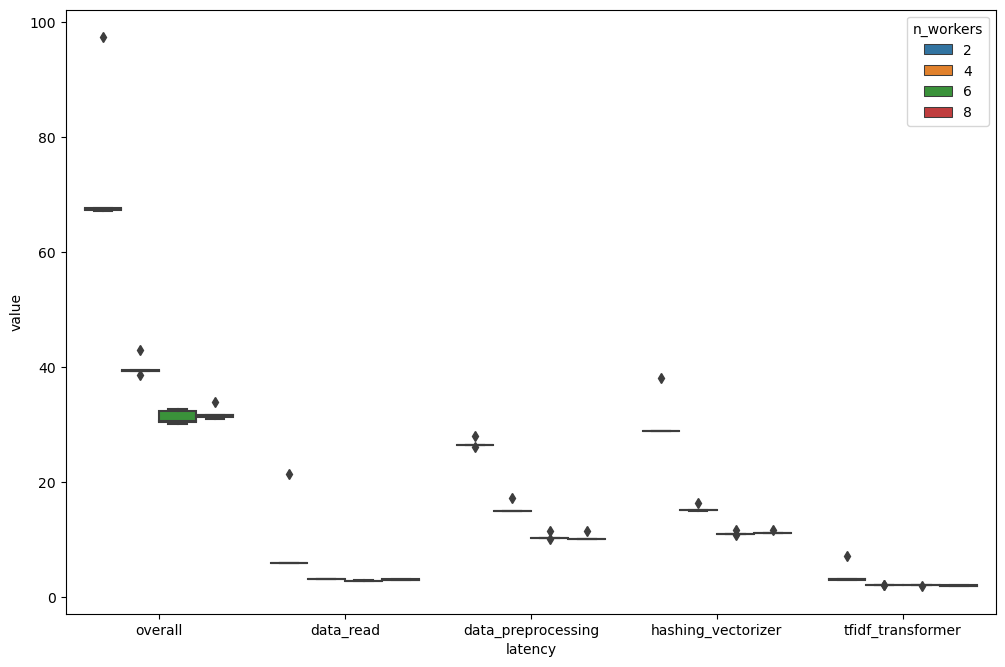

In [9]:
data, melt_data = visualize_data(result_path)        

In [10]:
groupy = data.groupby("n_workers").agg(['mean', 'std', 'count'])

In [11]:
groupy

sample_run                    overall                  data_read  \
                mean       std count       mean        std count      mean   
n_workers                                                                    
2                  2  1.581139     5  73.407924  13.411537     5  8.932737   
4                  2  1.581139     5  39.890486   1.768134     5  3.072704   
6                  2  1.581139     5  31.170064   1.190775     5  2.817000   
8                  2  1.581139     5  31.856732   1.134447     5  2.977461   

                          data_preprocessing  ...       hashing_vectorizer  \
                std count               mean  ... count               mean   
n_workers                                     ...                            
2          6.960586     5          26.642361  ...     5          30.666390   
4          0.023625     5          15.401698  ...     5          15.332111   
6          0.025480     5          10.416346  ...     5          11.033144   
8          0.059042     5          10.394802  ...     5          11.230452   

                          tfidf_transformer                     nrows       \
                std count              mean       std count      mean  std   
n_workers                                                                    
2          4.139648     5          3.828063  1.854937     5  20725971  0.0   
4          0.570090     5          2.023146  0.041773     5  20725971  0.0   
6          0.345978     5          1.986640  0.074961     5  20725971  0.0   
8          0.250232     5          1.936081  0.066259     5  20725971  0.0   

                 
          count  
n_workers        
2             5  
4             5  
6             5  
8             5  

[4 rows x 21 columns]

## Benchmark latency without materializing the intermediate dataframe(s) except for the last stage

In [13]:
#parquet_path = 's3://amazon-reviews-pds/parquet/product_category=Camera/*.parquet'
dataset = "Books"
parquet_path = f'./data/product_category={dataset}'
model_kwargs = {"text_preprocessor":text_preprocessor}
samples = 5
worker_counts = [2,4,6,8]
result_path = f"./results/result_poc_nlp_dask_{dataset}_nonpersist.pkl"

In [14]:
%%time
performance_numbers(client, parquet_path=parquet_path, worker_counts=worker_counts, samples=samples, result_path=result_path, persist_flag=False)

  0%|                                                                                                                                                                                      | 0/5 [00:00<?, ?it/s]distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize


20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(nan, 0)
[I] [09:44:21.692688] [Delayed('_merge_stats_to_model-da7522f5-1e30-43b3-bd22-584022ea6d14')]
[I] [09:44:21.696744] [Delayed('_merge_stats_to_model-88308a5d-3fb0-419e-a43c-13623fa2c531')]
[I] [09:44:21.748163] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-da7522f5-1e30-43b3-bd22-584022ea6d14>]
[I] [09:44:21.748432] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-88308a5d-3fb0-419e-a43c-13623fa2c531>]
[I] [09:44:21.757165] [Delayed('_merge_stats_to_model-4d57e91f-b172-4465-826b-07613affd9bc')]
(20725971, 1048576)
Workers:2, Sample Run:0, Finished loading data in 5336546500s
Workers:2, Sample Run:0, Finished preprocessing data in 27422734191s
Workers:2, Sample Run:0, Finished fitting HashVectorizer in 265011068s
Workers:2, Sample Run:0, Finished fitting IDF Transformer in 107059563715s


 20%|██████████████████████████████████▌                                                                                                                                          | 1/5 [02:55<11:41, 175.35s/it]

Workers:2, Sample Run:0, Finished executing full pipeline in 142959905293s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize


20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(nan, 0)
[I] [09:47:16.575931] [Delayed('_merge_stats_to_model-cdaa9116-1f87-4286-94fc-ca8fe66886c2')]
[I] [09:47:16.578155] [Delayed('_merge_stats_to_model-ec415bd2-0c96-429e-b7ae-3ba5a6e9ba8e')]
[I] [09:47:16.630981] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-cdaa9116-1f87-4286-94fc-ca8fe66886c2>]
[I] [09:47:16.631209] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-ec415bd2-0c96-429e-b7ae-3ba5a6e9ba8e>]
[I] [09:47:16.637360] [Delayed('_merge_stats_to_model-d7ae9daf-2bd0-4dd6-a8a3-01b1eecf477b')]
(20725971, 1048576)
Workers:2, Sample Run:1, Finished loading data in 4190261814s
Workers:2, Sample Run:1, Finished preprocessing data in 27548566451s
Workers:2, Sample Run:1, Finished fitting HashVectorizer in 10845088s
Workers:2, Sample Run:1, Finished fitting IDF Transformer in 109804482834s


 40%|█████████████████████████████████████████████████████████████████████▏                                                                                                       | 2/5 [05:47<08:40, 173.64s/it]

Workers:2, Sample Run:1, Finished executing full pipeline in 145005203901s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize


20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(nan, 0)
[I] [09:50:25.335409] [Delayed('_merge_stats_to_model-d6ea13bc-fefb-4e8b-8020-b5d6919d5d7b')]
[I] [09:50:25.337808] [Delayed('_merge_stats_to_model-b0dac340-0c8b-4e8f-bb2f-fcc775407317')]
[I] [09:50:25.386046] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-d6ea13bc-fefb-4e8b-8020-b5d6919d5d7b>]
[I] [09:50:25.386283] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-b0dac340-0c8b-4e8f-bb2f-fcc775407317>]
[I] [09:50:25.392032] [Delayed('_merge_stats_to_model-191f2367-0f6e-4941-ba6c-bcc1b64ba98a')]
(20725971, 1048576)
Workers:2, Sample Run:2, Finished loading data in 4020897133s
Workers:2, Sample Run:2, Finished preprocessing data in 38576817557s
Workers:2, Sample Run:2, Finished fitting HashVectorizer in 22325017s
Workers:2, Sample Run:2, Finished fitting IDF Transformer in 112619822485s


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 3/5 [08:58<06:03, 181.58s/it]

Workers:2, Sample Run:2, Finished executing full pipeline in 158652323116s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize


20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(nan, 0)
[I] [09:53:19.307265] [Delayed('_merge_stats_to_model-d7531071-76d2-428f-aa54-0157a220ed85')]
[I] [09:53:19.310073] [Delayed('_merge_stats_to_model-4207a0f3-5e5c-43a6-a990-b2b32b7c4e54')]
[I] [09:53:19.361244] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-d7531071-76d2-428f-aa54-0157a220ed85>]
[I] [09:53:19.361512] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-4207a0f3-5e5c-43a6-a990-b2b32b7c4e54>]
[I] [09:53:19.367635] [Delayed('_merge_stats_to_model-c72c993c-395e-4fb6-83f8-883ef36c833e')]
(20725971, 1048576)
Workers:2, Sample Run:3, Finished loading data in 3972658621s
Workers:2, Sample Run:3, Finished preprocessing data in 27378479364s
Workers:2, Sample Run:3, Finished fitting HashVectorizer in 7007492s
Workers:2, Sample Run:3, Finished fitting IDF Transformer in 106953880642s


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 4/5 [11:47<02:56, 176.66s/it]

Workers:2, Sample Run:3, Finished executing full pipeline in 141625654390s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize


20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(nan, 0)
[I] [09:56:24.490499] [Delayed('_merge_stats_to_model-b3804aae-87cf-4df5-afb6-cdcf966e8164')]
[I] [09:56:24.495155] [Delayed('_merge_stats_to_model-b010cec2-37f8-40e2-9843-e52218aa1e74')]
[I] [09:56:24.602420] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-b3804aae-87cf-4df5-afb6-cdcf966e8164>]
[I] [09:56:24.602914] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-b010cec2-37f8-40e2-9843-e52218aa1e74>]
[I] [09:56:24.631019] [Delayed('_merge_stats_to_model-3dac3d0c-4aaf-4d37-9ea0-5cc0f8ebf764')]
(20725971, 1048576)
Workers:2, Sample Run:4, Finished loading data in 4041494027s
Workers:2, Sample Run:4, Finished preprocessing data in 32615030138s
Workers:2, Sample Run:4, Finished fitting HashVectorizer in 9470402s
Workers:2, Sample Run:4, Finished fitting IDF Transformer in 126411438245s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [15:24<00:00, 184.88s/it]

Workers:2, Sample Run:4, Finished executing full pipeline in 166608613543s



distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
  0%|                                                                                                                                                                                      | 0/5 [00:00<?, ?it/s]/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home

20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(nan, 0)
[I] [09:59:32.169634] [Delayed('_merge_stats_to_model-339170ee-3eb6-4629-a9b8-b1c4e913d6c5')]
[I] [09:59:32.170779] [Delayed('_merge_stats_to_model-37df2e7a-77ce-42f7-ac6d-a3a694ef2391')]
[I] [09:59:32.172384] [Delayed('_merge_stats_to_model-a56dd720-9268-4246-b295-2ca85f3490c0')]
[I] [09:59:32.173280] [Delayed('_merge_stats_to_model-d8e499fe-2ab0-4ba9-9846-7fe227990eab')]
[I] [09:59:32.216076] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-339170ee-3eb6-4629-a9b8-b1c4e913d6c5>]
[I] [09:59:32.216405] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-37df2e7a-77ce-42f7-ac6d-a3a694ef2391>]
[I] [09:59:32.216708] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-a56dd720-9268-4246-b295-2ca85f3490c0>]
[I] [09:59:32.216861] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-d8e499fe-2ab0-4ba9-9846-7fe227990eab>]
[I] [09:59:32.228183] [Delayed('_merge_stats_to_m

 20%|██████████████████████████████████▌                                                                                                                                          | 1/5 [01:51<07:26, 111.54s/it]

Workers:4, Sample Run:0, Finished executing full pipeline in 94858470855s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when 

20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(nan, 0)
[I] [10:01:19.329146] [Delayed('_merge_stats_to_model-a5d52a1d-f0ba-4391-8e59-76bbb013dbbc')]
[I] [10:01:19.330857] [Delayed('_merge_stats_to_model-78e0247f-b926-4f09-b36d-bd18123f89ac')]
[I] [10:01:19.331668] [Delayed('_merge_stats_to_model-b3c81d17-47e5-46f7-9e1b-49be1ea93b88')]
[I] [10:01:19.332430] [Delayed('_merge_stats_to_model-2c62f3fb-82dd-4256-873f-ac4b52897cf3')]
[I] [10:01:19.372463] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-a5d52a1d-f0ba-4391-8e59-76bbb013dbbc>]
[I] [10:01:19.372714] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-78e0247f-b926-4f09-b36d-bd18123f89ac>]
[I] [10:01:19.372847] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-b3c81d17-47e5-46f7-9e1b-49be1ea93b88>]
[I] [10:01:19.372972] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-2c62f3fb-82dd-4256-873f-ac4b52897cf3>]
[I] [10:01:19.379586] [Delayed('_merge_stats_to_m

 40%|█████████████████████████████████████████████████████████████████████▏                                                                                                       | 2/5 [03:38<05:25, 108.63s/it]

Workers:4, Sample Run:1, Finished executing full pipeline in 90126531966s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when 

20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(nan, 0)
[I] [10:03:03.537979] [Delayed('_merge_stats_to_model-a4ed3c10-f54e-4165-9e8f-e24564029190')]
[I] [10:03:03.539204] [Delayed('_merge_stats_to_model-e18926fc-216d-48ca-a220-fce88c8c6bf1')]
[I] [10:03:03.540037] [Delayed('_merge_stats_to_model-d2cdc967-29a3-46c3-b8bd-f6a988f3149e')]
[I] [10:03:03.541363] [Delayed('_merge_stats_to_model-ece7c94a-ac6e-4a82-aa09-b13efd1af3e9')]
[I] [10:03:03.580284] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-a4ed3c10-f54e-4165-9e8f-e24564029190>]
[I] [10:03:03.580568] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-e18926fc-216d-48ca-a220-fce88c8c6bf1>]
[I] [10:03:03.580708] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-d2cdc967-29a3-46c3-b8bd-f6a988f3149e>]
[I] [10:03:03.580862] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-ece7c94a-ac6e-4a82-aa09-b13efd1af3e9>]
[I] [10:03:03.588180] [Delayed('_merge_stats_to_m

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 3/5 [05:22<03:33, 106.54s/it]

Workers:4, Sample Run:2, Finished executing full pipeline in 87566792661s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when 

20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(nan, 0)
[I] [10:04:50.270173] [Delayed('_merge_stats_to_model-7532ab1f-e7da-4671-951e-b5fd43faaf02')]
[I] [10:04:50.271951] [Delayed('_merge_stats_to_model-41d859ba-5a20-4805-9af6-5db9498cfac8')]
[I] [10:04:50.273215] [Delayed('_merge_stats_to_model-d576a9fb-12b7-4c50-9f91-3db5c5c8b9b6')]
[I] [10:04:50.273868] [Delayed('_merge_stats_to_model-71b2fff9-ab91-4533-9ad4-ef128fc25727')]
[I] [10:04:50.315801] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-7532ab1f-e7da-4671-951e-b5fd43faaf02>]
[I] [10:04:50.316059] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-41d859ba-5a20-4805-9af6-5db9498cfac8>]
[I] [10:04:50.316203] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-d576a9fb-12b7-4c50-9f91-3db5c5c8b9b6>]
[I] [10:04:50.316334] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-71b2fff9-ab91-4533-9ad4-ef128fc25727>]
[I] [10:04:50.322879] [Delayed('_merge_stats_to_m

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 4/5 [07:13<01:48, 108.43s/it]

Workers:4, Sample Run:3, Finished executing full pipeline in 92170863406s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when 

20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(nan, 0)
[I] [10:06:40.779244] [Delayed('_merge_stats_to_model-63036534-6326-45e3-8dd5-1a2cef9dc0a2')]
[I] [10:06:40.780971] [Delayed('_merge_stats_to_model-4bce250c-8421-4b1d-a1f7-31a3587778f8')]
[I] [10:06:40.781702] [Delayed('_merge_stats_to_model-8af32288-d7e8-49f6-abc0-7366189fd77e')]
[I] [10:06:40.782479] [Delayed('_merge_stats_to_model-4723c118-9ab7-452d-b7d9-cc6de7db4936')]
[I] [10:06:40.821704] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-63036534-6326-45e3-8dd5-1a2cef9dc0a2>]
[I] [10:06:40.821942] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-4bce250c-8421-4b1d-a1f7-31a3587778f8>]
[I] [10:06:40.822085] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-8af32288-d7e8-49f6-abc0-7366189fd77e>]
[I] [10:06:40.822212] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-4723c118-9ab7-452d-b7d9-cc6de7db4936>]
[I] [10:06:40.828788] [Delayed('_merge_stats_to_m

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:59<00:00, 107.92s/it]

Workers:4, Sample Run:4, Finished executing full pipeline in 89657194787s



distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
  0%|                                                                                                                                                                                      | 0/5 [00:00<?, ?it/s]/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home

20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(nan, 0)
[I] [10:08:16.064728] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-4045d5af-4504-45a2-96b6-2769906eb6b4>]
[I] [10:08:16.065753] [Delayed('_merge_stats_to_model-a1361df4-8e2c-4ebd-86d4-cbdba00027ac')]
[I] [10:08:16.066581] [Delayed('_merge_stats_to_model-c432893d-38e5-4d3f-bc14-58b649e90029')]
[I] [10:08:16.067475] [Delayed('_merge_stats_to_model-44208fff-5b4b-4059-90fd-9d5e0b09abdc')]
[I] [10:08:16.068420] [Delayed('_merge_stats_to_model-e174f7b8-cc2a-4b4c-a3e0-e1743ea1f12c')]
[I] [10:08:16.068705] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-19be48d5-7d8f-4fdc-8225-2dfe67b9acbd>]
[I] [10:08:16.094726] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-4045d5af-4504-45a2-96b6-2769906eb6b4>]
[I] [10:08:16.094959] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-a1361df4-8e2c-4ebd-86d4-cbdba00027ac>]
[I] [10:08:16.095100] [<Future: finished, type: cuml.TfidfTransformer,

 20%|██████████████████████████████████▊                                                                                                                                           | 1/5 [01:16<05:07, 76.80s/it]

Workers:6, Sample Run:0, Finished executing full pipeline in 63823066049s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when 

20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(nan, 0)
[I] [10:09:36.276709] [Delayed('_merge_stats_to_model-aa62c99d-8412-457c-bc4f-20f90c68785f')]
[I] [10:09:36.277626] [Delayed('_merge_stats_to_model-ae86d039-6a7b-4327-a6b2-274340aea977')]
[I] [10:09:36.278400] [Delayed('_merge_stats_to_model-c935afaf-d010-4d23-9dd3-d9dbfbeb532b')]
[I] [10:09:36.278654] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-27cf9365-58e5-475f-961b-2d6c9b1af7af>]
[I] [10:09:36.278793] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-bd290595-5302-44cb-887e-0793a4d312ed>]
[I] [10:09:36.279504] [Delayed('_merge_stats_to_model-54d36997-0831-4f96-9a06-7010b50271c0')]
[I] [10:09:36.302443] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-aa62c99d-8412-457c-bc4f-20f90c68785f>]
[I] [10:09:36.302702] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-ae86d039-6a7b-4327-a6b2-274340aea977>]
[I] [10:09:36.302842] [<Future: finished, type: cuml.TfidfTrans

 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 2/5 [02:37<03:56, 78.94s/it]

Workers:6, Sample Run:1, Finished executing full pipeline in 68640305619s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when 

20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(nan, 0)
[I] [10:10:57.019361] [Delayed('_merge_stats_to_model-4ec9219f-57d0-4d00-9624-370867d5cf48')]
[I] [10:10:57.020482] [Delayed('_merge_stats_to_model-6d1b3573-08f0-4705-a084-6cf75344e7c2')]
[I] [10:10:57.021203] [Delayed('_merge_stats_to_model-060a5786-a169-49d6-b131-5254fdcfbe04')]
[I] [10:10:57.022323] [Delayed('_merge_stats_to_model-80146cae-812c-4968-9d39-c584abe0c37f')]
[I] [10:10:57.022598] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-afe903c5-9f0f-4fa0-8742-b8475c34862b>]
[I] [10:10:57.022745] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-07a16be7-f75b-466f-9080-c2fe40a4387f>]
[I] [10:10:57.052038] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-4ec9219f-57d0-4d00-9624-370867d5cf48>]
[I] [10:10:57.052276] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-6d1b3573-08f0-4705-a084-6cf75344e7c2>]
[I] [10:10:57.052415] [<Future: finished, type: cuml.TfidfTrans

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 3/5 [04:09<02:50, 85.19s/it]

Workers:6, Sample Run:2, Finished executing full pipeline in 79642011769s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when 

20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(nan, 0)
[I] [10:12:26.325189] [Delayed('_merge_stats_to_model-1e75695d-5a5b-41c8-850c-b39ebfa6e78d')]
[I] [10:12:26.326333] [Delayed('_merge_stats_to_model-80d133c8-1e8e-4d89-bf3d-235108b9fd93')]
[I] [10:12:26.326609] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-d8d3181a-6a96-4eb4-9187-26a0a5def361>]
[I] [10:12:26.326785] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-f8eb5eb0-4d5c-40d2-8184-ce7d2297ba49>]
[I] [10:12:26.327664] [Delayed('_merge_stats_to_model-53dcfea4-a3fb-4f51-8f23-410ab7164d05')]
[I] [10:12:26.328559] [Delayed('_merge_stats_to_model-3a6a7095-30b8-4c0c-afcd-74704be8a5d7')]
[I] [10:12:26.356325] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-1e75695d-5a5b-41c8-850c-b39ebfa6e78d>]
[I] [10:12:26.356583] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-80d133c8-1e8e-4d89-bf3d-235108b9fd93>]
[I] [10:12:26.356752] [<Future: finished, type: cuml.TfidfTrans

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4/5 [05:27<01:22, 82.04s/it]

Workers:6, Sample Run:3, Finished executing full pipeline in 64464742893s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when 

20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(nan, 0)
[I] [10:13:43.460356] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-1258763c-7e30-439b-9f35-a376b7c1bf29>]
[I] [10:13:43.461451] [Delayed('_merge_stats_to_model-674211d9-6ed7-48c5-a389-8702a4223a10')]
[I] [10:13:43.462247] [Delayed('_merge_stats_to_model-56ac4496-ba01-49ba-bf91-1e63e7389eef')]
[I] [10:13:43.462478] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-00c00b8a-24b5-41ae-ad6c-a823e39df4db>]
[I] [10:13:43.463189] [Delayed('_merge_stats_to_model-facdfbbb-489b-4ee2-9b0c-553212fd88c7')]
[I] [10:13:43.464001] [Delayed('_merge_stats_to_model-de0449e8-8f4d-4634-a82d-382988d357b8')]
[I] [10:13:43.491485] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-1258763c-7e30-439b-9f35-a376b7c1bf29>]
[I] [10:13:43.491717] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-674211d9-6ed7-48c5-a389-8702a4223a10>]
[I] [10:13:43.492034] [<Future: finished, type: cuml.TfidfTransformer,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:44<00:00, 80.89s/it]

Workers:6, Sample Run:4, Finished executing full pipeline in 64498062988s



distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
  0%|                                                                                                                                                                                      | 0/5 [00:00<?, ?it/s]/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home

20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(nan, 0)
[I] [10:15:06.123076] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-ef239a59-1c6e-411b-8cf7-0ed100d97d2f>]
[I] [10:15:06.123981] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-871de83a-9034-4f15-a688-51599e71b1ff>]
[I] [10:15:06.124204] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-7238fc8d-518c-4544-9fc8-f57d9486fdf8>]
[I] [10:15:06.125138] [Delayed('_merge_stats_to_model-3f2a8eac-c7b0-45d0-abd4-ee685a04a714')]
[I] [10:15:06.125388] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-8b6a9177-0ee1-4f07-84b0-18d65746f13c>]
[I] [10:15:06.125536] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-e6a3fcee-c599-4fa7-a6fb-6876ba8bd705>]
[I] [10:15:06.126275] [Delayed('_merge_stats_to_model-b8f4f424-59e4-447e-b26d-b1b8137c4fb6')]
[I] [10:15:06.126529] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-dcf83064-b124-423d-ab61-4840c939b768>]
[I] [

 20%|██████████████████████████████████▊                                                                                                                                           | 1/5 [01:19<05:19, 79.90s/it]

Workers:8, Sample Run:0, Finished executing full pipeline in 65669242181s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when 

20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(nan, 0)
[I] [10:16:27.195676] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-0ea2883c-7f4e-4d01-a2a2-d4078e983ca8>]
[I] [10:16:27.196227] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-aa7132f0-b9d6-4a79-b5d9-1ee97f3e16e5>]
[I] [10:16:27.197133] [Delayed('_merge_stats_to_model-cd0443e8-194b-47e7-b3f3-7851dd8615bf')]
[I] [10:16:27.197401] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-ac8ec248-7668-446b-b131-58c9f07d8625>]
[I] [10:16:27.197546] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-0148430c-6ff0-4140-a0ca-fc802c95970f>]
[I] [10:16:27.197677] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-e163ad75-323b-4939-80bb-9d2392d91622>]
[I] [10:16:27.198390] [Delayed('_merge_stats_to_model-002b7a1c-753f-46ea-add4-84c8eabcc99a')]
[I] [10:16:27.198648] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-2353cbd4-31b6-40da-ad27-cb3c62d46367>]
[I] [

 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 2/5 [02:36<03:54, 78.24s/it]

Workers:8, Sample Run:1, Finished executing full pipeline in 65774004310s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when 

20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(nan, 0)
[I] [10:17:42.371057] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-3f63d3bc-20d8-4afc-b0d1-8dd70488b5cb>]
[I] [10:17:42.371433] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-32630619-7ddc-4d4a-b9ec-4db4b040542a>]
[I] [10:17:42.371634] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-5c602d91-c2c9-45d6-864d-bf7f9ae8ac27>]
[I] [10:17:42.371780] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-5a992bfd-2ee8-46ad-9fd4-29d32cc8bbf1>]
[I] [10:17:42.372718] [Delayed('_merge_stats_to_model-a054710a-f05b-4931-a97f-bed08bd45e9d')]
[I] [10:17:42.372986] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-6dc7c7e0-1750-41a8-8f46-cc79451da826>]
[I] [10:17:42.373131] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-7d2070c8-e326-4f77-9bb3-12e8233cfc5b>]
[I] [10:17:42.373829] [Delayed('_merge_stats_to_model-68393187-9913-4e3f-86a0-8f6970461792')]
[I] [

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 3/5 [03:52<02:33, 76.83s/it]

Workers:8, Sample Run:2, Finished executing full pipeline in 63832380294s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when 

20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(nan, 0)
[I] [10:18:57.809239] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-0dda5a77-cbd2-4aeb-af2d-665ca147fb56>]
[I] [10:18:57.810560] [Delayed('_merge_stats_to_model-cccc561f-f77b-4487-98e9-746eaebeefa3')]
[I] [10:18:57.810806] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-735ed3be-49f4-4668-9c60-2e3841fde0f8>]
[I] [10:18:57.811465] [Delayed('_merge_stats_to_model-8c9e3768-b290-45f4-83b0-2b1e390df6a6')]
[I] [10:18:57.811759] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-9d551129-d815-4c08-9f6f-62d791044a6e>]
[I] [10:18:57.811986] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-e8b09868-7e2f-40cc-8a23-2355515effd5>]
[I] [10:18:57.812113] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-a4aa94dc-d031-4b5e-8687-237c4c933aab>]
[I] [10:18:57.812255] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-5f077aff-e131-4e5b-b543-19e91feaee31>]
[I] [

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4/5 [05:07<01:16, 76.25s/it]

Workers:8, Sample Run:3, Finished executing full pipeline in 63734186929s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when 

20726160


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


20725971
# nnz: 0
(nan, 0)
[I] [10:20:12.789887] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-bf379e9e-d953-4c16-be08-0a95acf4d2c8>]
[I] [10:20:12.790447] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-5531912c-9076-404c-b676-08d0a912dd8e>]
[I] [10:20:12.791291] [Delayed('_merge_stats_to_model-c02ad7b9-cea8-4b63-8f61-b1fbb28306bd')]
[I] [10:20:12.791516] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-e6612a98-aa1b-4ac0-9e03-eef7931c304d>]
[I] [10:20:12.791721] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-ea3c0ef0-db02-4637-9b18-27a806779c5d>]
[I] [10:20:12.791937] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-4037d081-af4d-446e-ad49-2baf59a3a30e>]
[I] [10:20:12.792065] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-2bc65d88-1b4a-4f69-9a02-decc370fddcb>]
[I] [10:20:12.792762] [Delayed('_merge_stats_to_model-4e2055b5-f325-45b5-8e8d-42868110849e')]
[I] [

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:22<00:00, 76.47s/it]

Workers:8, Sample Run:4, Finished executing full pipeline in 63520376470s
CPU times: user 1min 32s, sys: 24.7 s, total: 1min 57s
Wall time: 37min 56s


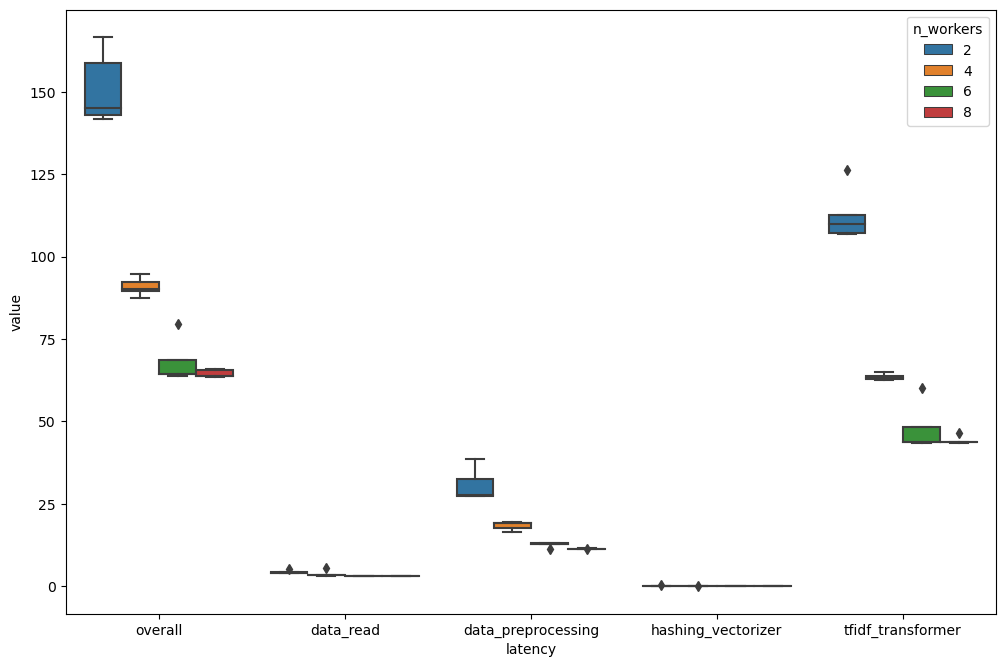

In [15]:
data, melt_data = visualize_data(result_path)        

In [16]:
groupy = data.groupby("n_workers").agg(['mean', 'std', 'count'])

In [17]:
groupy

sample_run                     overall                  data_read  \
                mean       std count        mean        std count      mean   
n_workers                                                                     
2                  2  1.581139     5  150.970340  11.075215     5  4.312372   
4                  2  1.581139     5   90.875971   2.762915     5  3.843371   
6                  2  1.581139     5   68.213638   6.669457     5  3.010626   
8                  2  1.581139     5   64.506038   1.116006     5  3.066152   

                          data_preprocessing  ...       hashing_vectorizer  \
                std count               mean  ... count               mean   
n_workers                                     ...                            
2          0.578269     5          30.708326  ...     5           0.062932   
4          0.975585     5          18.361575  ...     5           0.010076   
6          0.068762     5          12.666525  ...     5           0.008308   
8          0.073139     5          11.387442  ...     5           0.008243   

                          tfidf_transformer                     nrows       \
                std count              mean       std count      mean  std   
n_workers                                                                    
2          0.113119     5        112.569838  8.079939     5  20725971  0.0   
4          0.003225     5         63.446166  0.934239     5  20725971  0.0   
6          0.001107     5         47.881598  7.196582     5  20725971  0.0   
8          0.001027     5         44.209946  1.187079     5  20725971  0.0   

                 
          count  
n_workers        
2             5  
4             5  
6             5  
8             5  

[4 rows x 21 columns]

In [18]:
client.close()
cluster.close()

/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when 